# Projet Deep Learning
by Thomas ODIN, Maïa JOUENNE et Benoit CATEZ

## Import et telechargement des paquets necessaires

In [32]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

## 1) Classification

### Crop et annotation

Number of valid cropped images: 2075
Image sizes:
(106, 169, 3)    6
(70, 64, 3)      6
(43, 72, 3)      4
(2, 1, 3)        4
(131, 262, 3)    4
                ..
(93, 56, 3)      1
(87, 41, 3)      1
(72, 70, 3)      1
(51, 61, 3)      1
(53, 84, 3)      1
Name: cropped_image, Length: 1023, dtype: int64


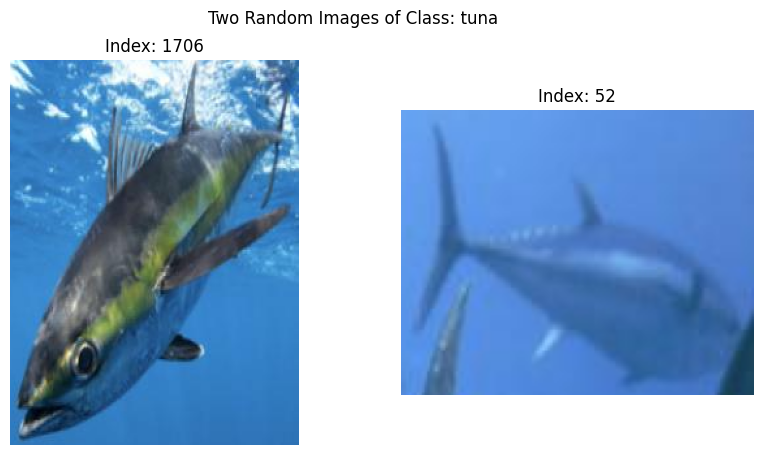

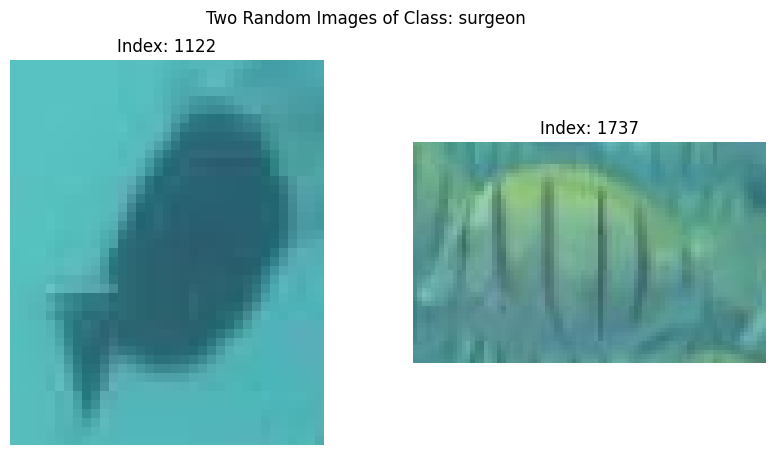

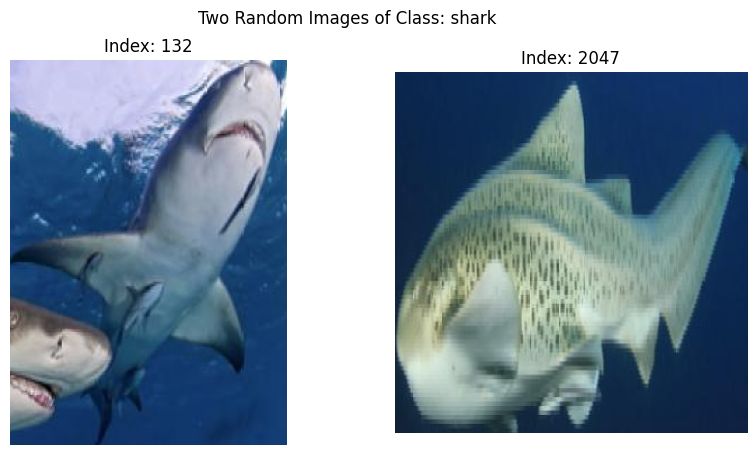

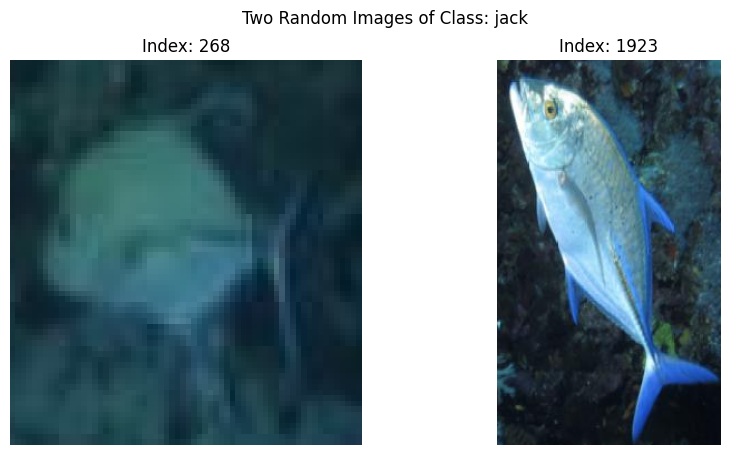

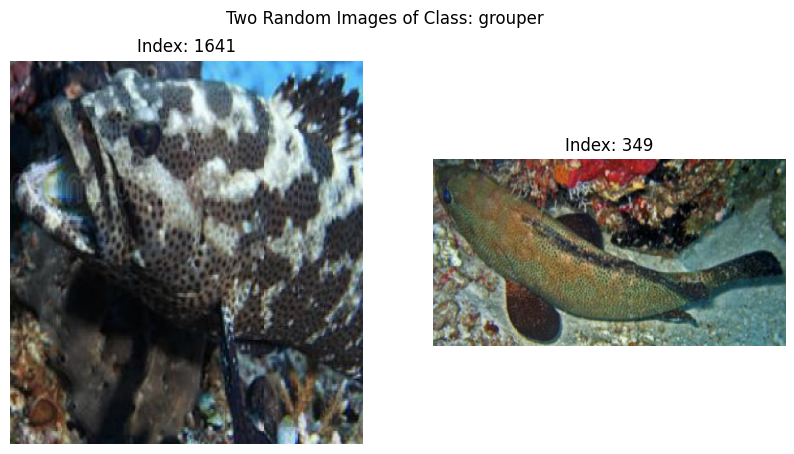

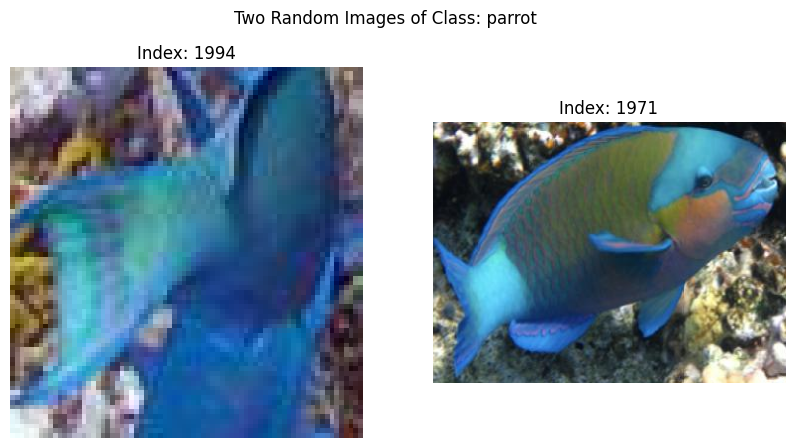

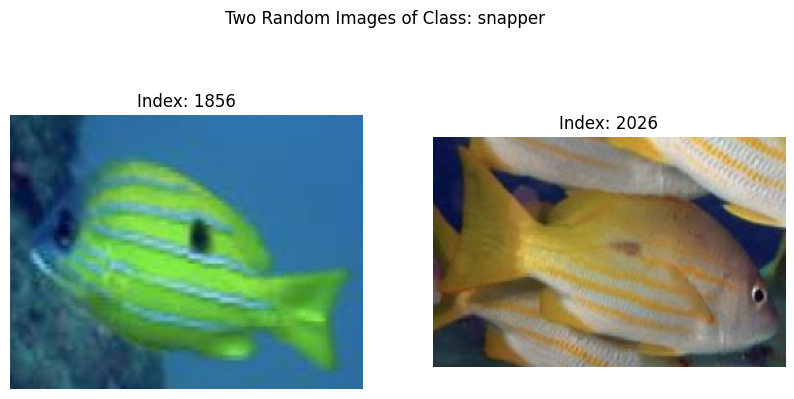

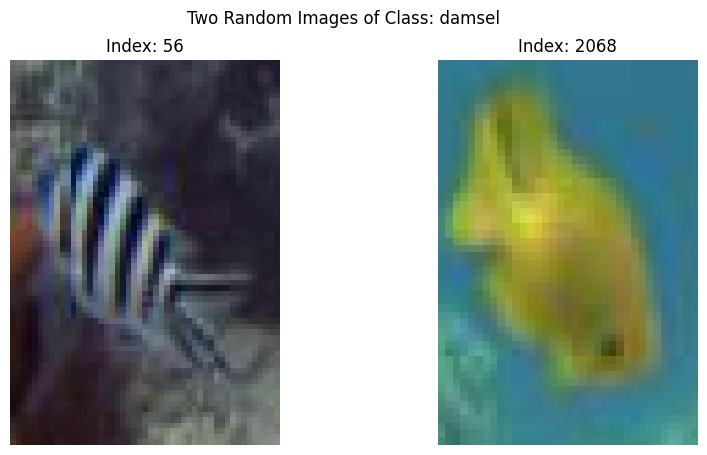

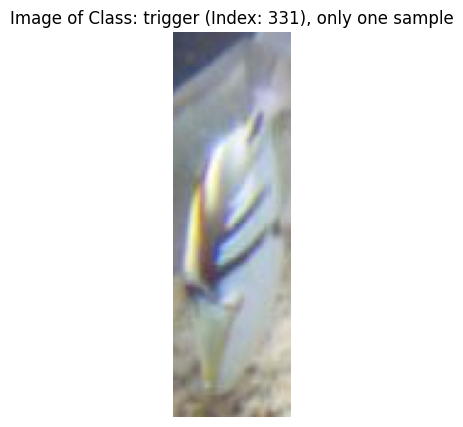

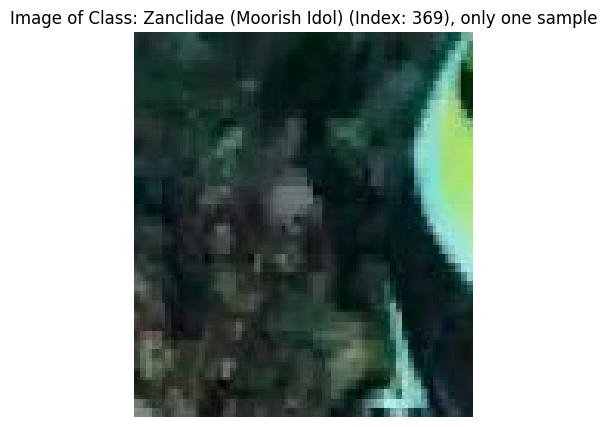

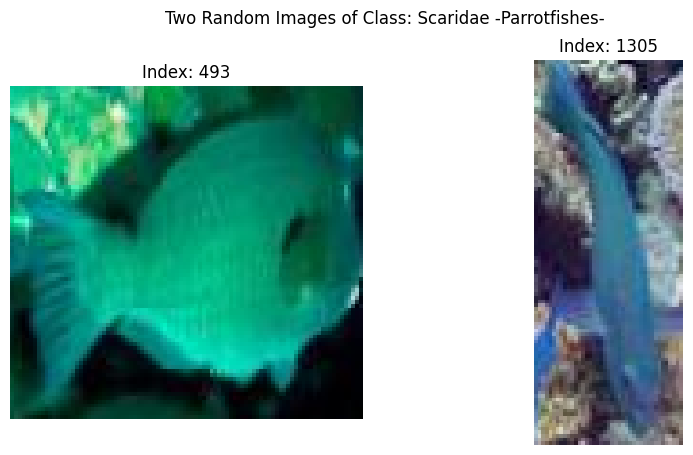

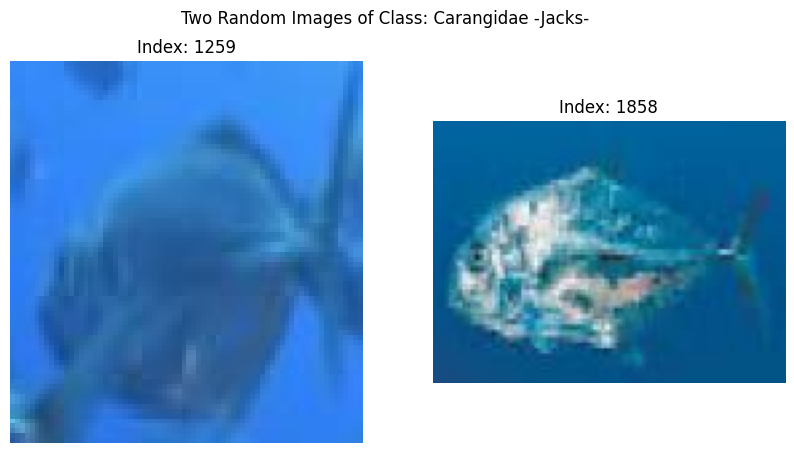

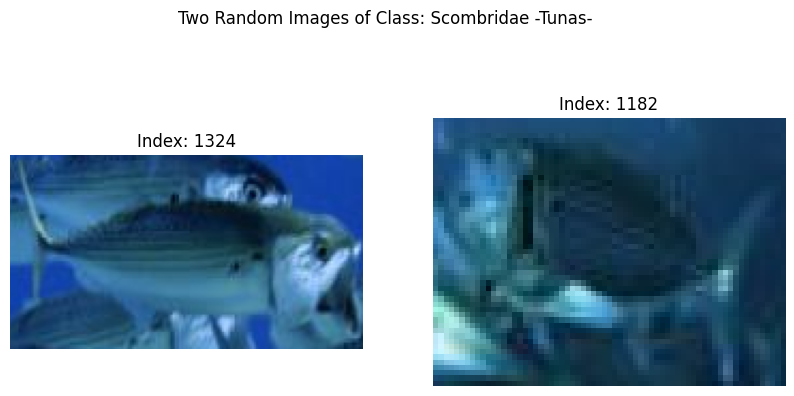

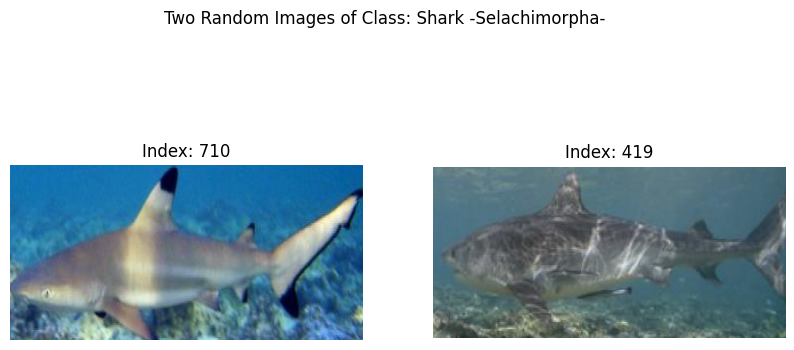

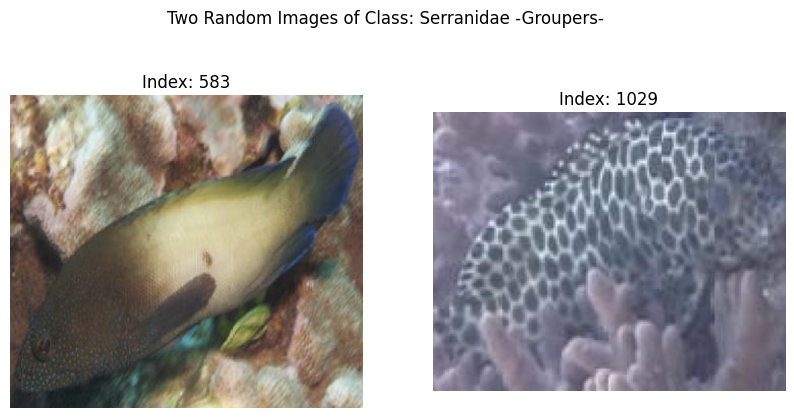

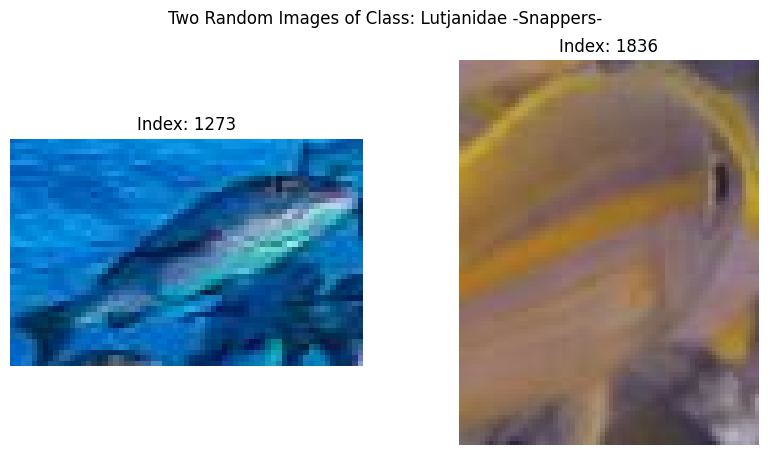

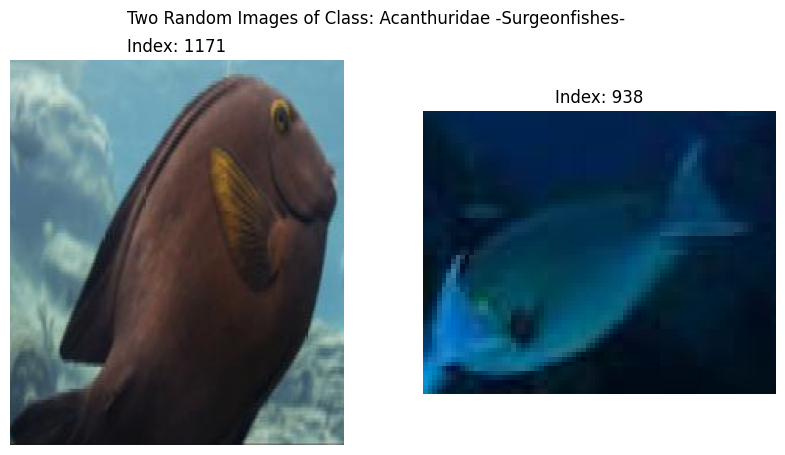

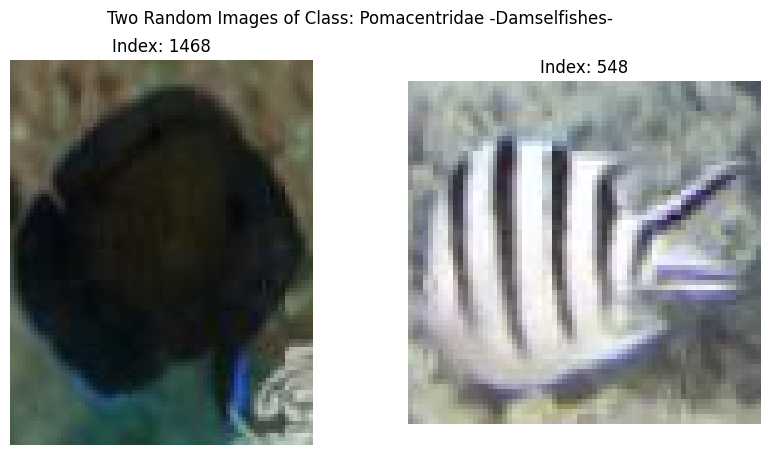

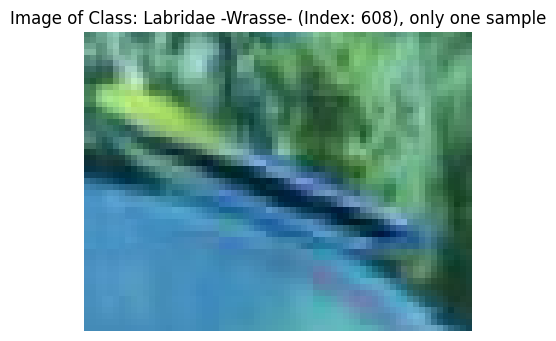

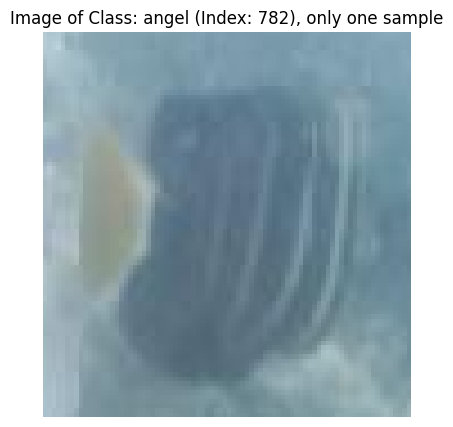

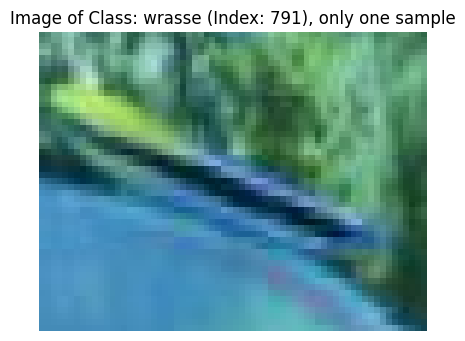

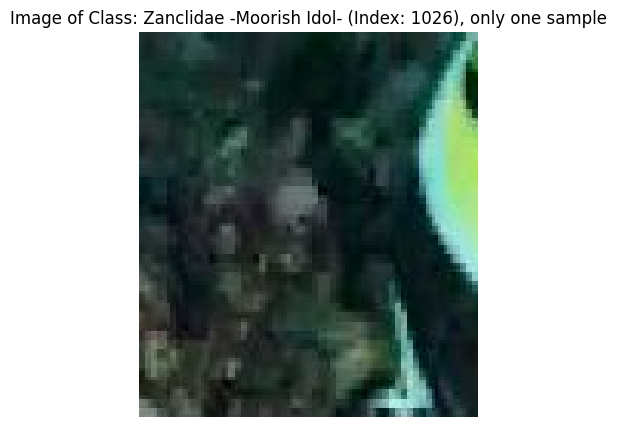

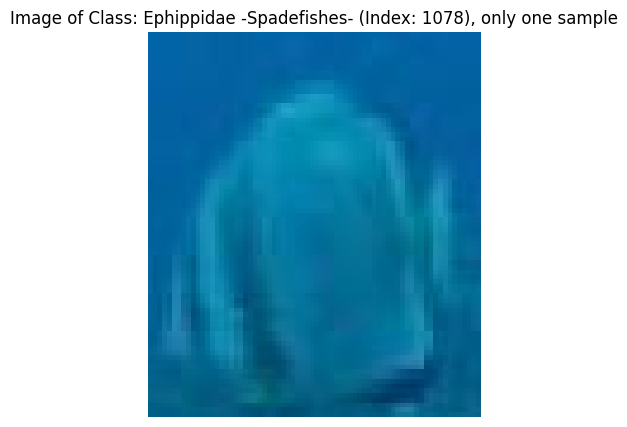

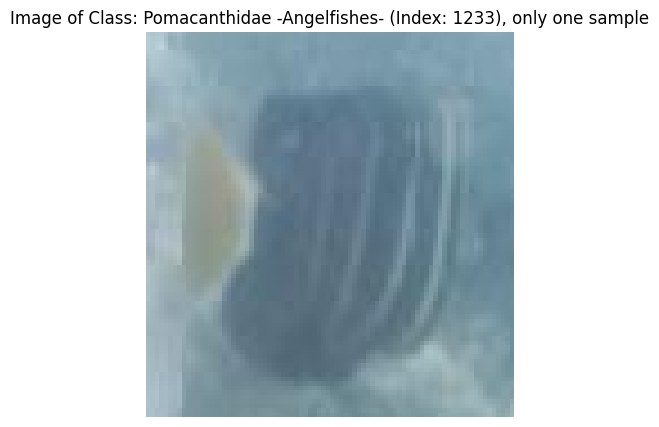

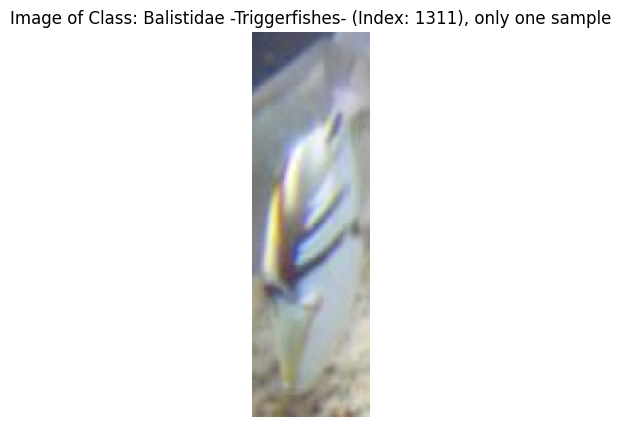

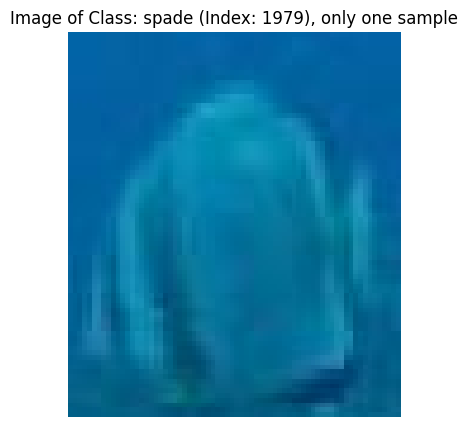

In [34]:
# Read the CSV file into a DataFrame
df_train = pd.read_csv('data/train/_annotations.csv')

# Read and store cropped images
cropped_image_list = []

for index, row in df_train.iterrows():
    image_path = row['filename']
    image = Image.open('data/train/' + image_path)

    # Extract cropping coordinates
    xmin, ymin, xmax, ymax = (
        max(0, row['xmin']),
        max(0, row['ymin']),
        min(image.width, row['xmax']),
        min(image.height, row['ymax'])
    )

    # Check if the adjusted coordinates are valid
    if xmin < xmax and ymin < ymax:
        # Crop the image
        cropped_image = np.array(image.crop((xmin, ymin, xmax, ymax)))

        # Store the cropped image in the list
        cropped_image_list.append(cropped_image)
    else:
        # If the coordinates are invalid, append a placeholder (e.g., None)
        cropped_image_list.append(None)

# Add a new column to the DataFrame with cropped images
df_train['cropped_image'] = cropped_image_list

# Filter out rows with None values in the 'cropped_image' column
df_valid_crops = df_train.dropna(subset=['cropped_image'])

# Display general information
print("Number of valid cropped images:", len(df_valid_crops))
print("Image sizes:")
print(df_valid_crops['cropped_image'].apply(lambda x: x.shape).value_counts())

# Get unique classes in the DataFrame
unique_classes = df_valid_crops['class'].unique()

# Number of random images to plot for each class
images_to_plot = 2

# Plot two random images for each class
for class_name in unique_classes:
    # Filter DataFrame based on the current class
    df_same_class = df_valid_crops[df_valid_crops['class'] == class_name]

    # Check the number of images in the current class
    num_images = len(df_same_class)

    if num_images >= images_to_plot:
        # Randomly select two images from the current class
        random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

        # Plot the two random images for the current class
        fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
        fig.suptitle(f'Two Random Images of Class: {class_name}')

        for i, ax in enumerate(axes):
            ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
            ax.set_title(f"Index: {random_indices[i]}")
            ax.axis('off')

        plt.show()
    elif num_images == 1:
        # Plot the single image for the current class
        plt.figure(figsize=(5, 5))
        plt.imshow(df_same_class.iloc[0]['cropped_image'])
        plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]}), only one sample')
        plt.axis('off')
        plt.show()
    else:
        print(f"No images of class '{class_name}' for plotting.")


We can see that some of the classes are the same but with different name and that some of the picture are very pixelized. So we are going to do some mapping for the classes and create a function to automate the recuperation of the data 

### Classification

#### Création du modèle

#### Entrainement et Evaluation du modele

## 2) Transfer Learning